# Basic Initialization

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import graphviz

In [ ]:
# This cell is for fetcching dataset from UC Irvine
# 16 features
# 2111 raw data points
# UC Irvine - "77% of the data was generated synthetically using the Weka tool and the SMOTE filter, 23% of the data was collected directly from users through a web platform."
# Related Data Article is accessible here >> https://doi.org/10.1016/j.dib.2019.104344

from ucimlrepo import fetch_ucirepo 

# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 

# data (as pandas dataframes) 
raw_X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
raw_y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets 

# metadata 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.metadata) 

# variable information 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.variables) 

# raw_X.describe()

# Creating a combined df for analysis
raw_combined_df = pd.concat([raw_X, raw_y], axis=1)


{'uci_id': 544, 'name': 'Estimation of Obesity Levels Based On Eating Habits and Physical Condition ', 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition', 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv', 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2111, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': ['Gender', 'Age'], 'target_col': ['NObeyesdad'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Sep 10 2024', 'dataset_doi': '10.24432/C5H31Z', 'creators': [], 'intro_paper': {'ID': 358, 'type': 

# Data Preprocessing

In [96]:
# No null values are found accross the dataset, so we can move forward with the raw dataset
print(raw_X.isnull().sum())
# The main page of the dataset also lists that no missing values in any attributes are found in any data points

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64


In [97]:
raw_X.dtypes
# raw_y.dtypes


Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object

### Data Preprocessing - Converting attributes to numerical values
Some attributes are originally stored as 'yes' or 'no' objects. Here they're converted to 1.0 or 2.0 respectively as float64.
Attributes that have possible values are converted to a scale wherever possibel in order to require the least complexity from the decision tree. For example, CAEC can have 'Sometimes', 'Frequently', 'Always' or 'no'. When converted to numerics however, the order is changed respectively. 'no' is set to 0, 'sometimes' is set to 1, and so on. This became difficult when converting MTRANS, so we built a corellation matrix (found below) to determine the best order for a simpler decision tree.

In [98]:
print(raw_X["Gender"].unique())

['Female' 'Male']


In [99]:
print(raw_X["family_history_with_overweight"].unique())

['yes' 'no']


In [100]:
print(raw_X["FAVC"].unique())

['no' 'yes']


In [101]:
print(raw_X["CAEC"].unique())

['Sometimes' 'Frequently' 'Always' 'no']


In [102]:
print(raw_X["SMOKE"].unique())

['no' 'yes']


In [103]:
print(raw_X["SCC"].unique())

['no' 'yes']


In [104]:
print(raw_X["CALC"].unique())

['no' 'Sometimes' 'Frequently' 'Always']


In [105]:
print(raw_X["MTRANS"].unique())

['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']


In [106]:
# raw_y.describe()
print(raw_y["NObeyesdad"].unique())

['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


In [107]:
correlation_table = pd.crosstab(raw_X["MTRANS"], raw_y["NObeyesdad"])
print(correlation_table)

NObeyesdad             Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
MTRANS                                                                      
Automobile                              46             45             110   
Bike                                     0              4               0   
Motorbike                                0              6               3   
Public_Transportation                  220            200             236   
Walking                                  6             32               2   

NObeyesdad             Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
MTRANS                                                                         
Automobile                          95                 1                  66   
Bike                                 1                 0                   2   
Motorbike                            0                 0                   1   
Public_Transportation              200               323    

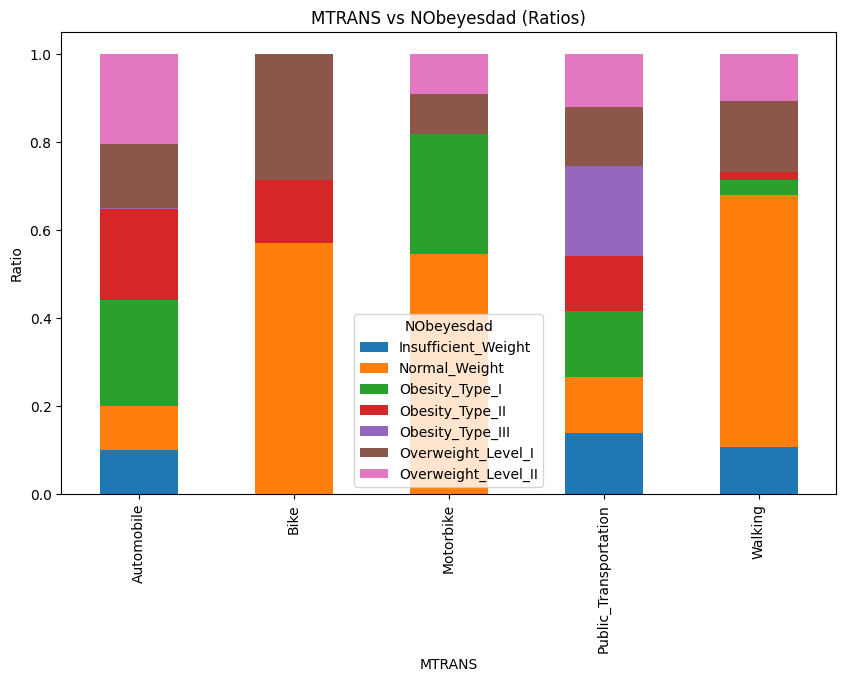

In [108]:
correlation_ratio = pd.crosstab(raw_X["MTRANS"], raw_y["NObeyesdad"], normalize='index')
correlation_ratio.plot(kind="bar", stacked=True, figsize=(10,6))
plt.ylabel("Ratio")
plt.title("MTRANS vs NObeyesdad (Ratios)")
plt.show()

In [109]:
cleaned_X = raw_X.copy()

# Converting Gender
cleaned_X["Gender"] = cleaned_X["Gender"].replace({"Female": 1, "Male": 2})
cleaned_X["Gender"] = cleaned_X["Gender"].infer_objects(copy=False).astype("float64")

# Converting 'family_history_with_overweight'
cleaned_X["family_history_with_overweight"] = cleaned_X["family_history_with_overweight"].replace({"yes": 1, "no": 2})
cleaned_X["family_history_with_overweight"] = cleaned_X["family_history_with_overweight"].infer_objects(copy=False).astype("float64")

# Converting FAVC
# FAVC - Do you eat high caloric food frequently?
cleaned_X["FAVC"] = cleaned_X["FAVC"].replace({"yes": 1, "no": 2})
cleaned_X["FAVC"] = cleaned_X["FAVC"].infer_objects(copy=False).astype("float64")

# Converting CAEC
# CAEC - Do you eat any food between meals?
cleaned_X["CAEC"] = cleaned_X["CAEC"].replace({"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3})
cleaned_X["CAEC"] = cleaned_X["CAEC"].infer_objects(copy=False).astype("float64")

# Converting SMOKE
# SMOKE - Do you smoke?
cleaned_X["SMOKE"] = cleaned_X["SMOKE"].replace({"yes": 1, "no": 2})
cleaned_X["SMOKE"] = cleaned_X["SMOKE"].infer_objects(copy=False).astype("float64")

# Converting SCC
# SCC - Do you monitor the calories you eat daily?
cleaned_X["SCC"] = cleaned_X["SCC"].replace({"yes": 1, "no": 2})
cleaned_X["SCC"] = cleaned_X["SCC"].infer_objects(copy=False).astype("float64")

# Converting CALC
# CALC - How often do you drink alcohol
cleaned_X["CALC"] = cleaned_X["CALC"].replace({"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3})
cleaned_X["CALC"] = cleaned_X["CALC"].infer_objects(copy=False).astype("float64")

# Converting MTRANS
# MTRANS - Which transportation do you usually use?
cleaned_X["MTRANS"] = cleaned_X["MTRANS"].replace({"Automobile": 0, "Motorbike": 1, "Frequently": 2, "Walking": 3})
cleaned_X["MTRANS"] = cleaned_X["MTRANS"].infer_objects(copy=False).astype("float64")


# Converting NObeyesdad

C:\Users\Thejas\AppData\Local\Temp\ipykernel_36384\1052051282.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_X["Gender"] = cleaned_X["Gender"].replace({"Female": 1, "Male": 2})
C:\Users\Thejas\AppData\Local\Temp\ipykernel_36384\1052051282.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_X["family_history_with_overweight"] = cleaned_X["family_history_with_overweight"].replace({"yes": 1, "no": 2})
C:\Users\Thejas\AppData\Local\Temp\ipykernel_36384\1052051282.py:13: FutureWarning: Downcasting behavior in `repl

ValueError: could not convert string to float: 'Public_Transportation'

In [ ]:
raw_X.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


### Data Preprocessing - Standardization and Normalization
Dataset is already standardized and normalized, so this code is redundant

In [ ]:
# # standardize and normalize the features
# from sklearn.preprocessing import StandardScaler
# std_scaler = StandardScaler()

# y_scaled = y

# X_scaled = std_scaler.fit_transform(X)

# X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# X_scaled.head()


# # Creating a combined df for analysis
# combined_df_scaled = pd.concat([X, y], axis=1)

# Dataset Analysis

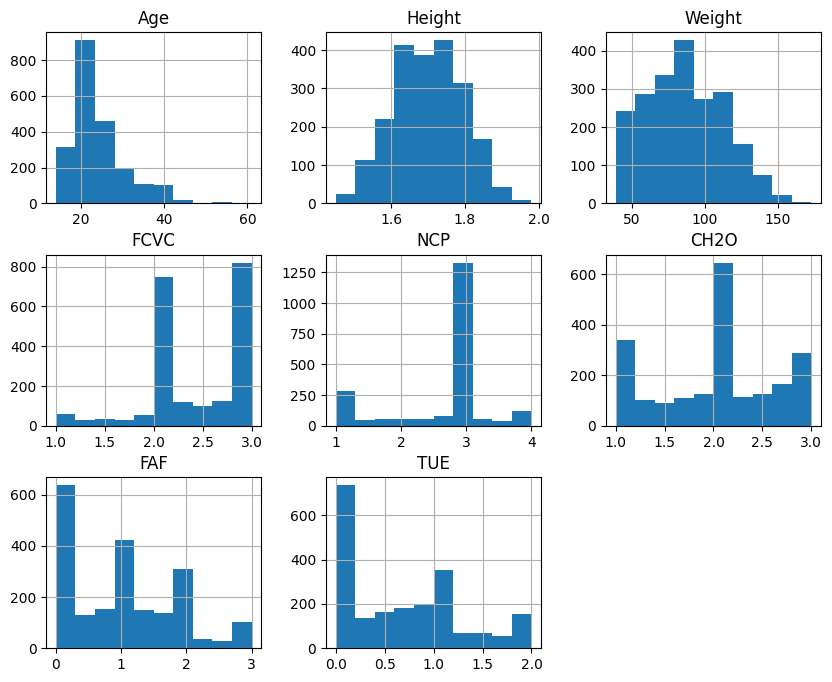

In [ ]:
raw_X.hist(figsize=(10, 8), bins=10)
plt.show()

<Axes: >

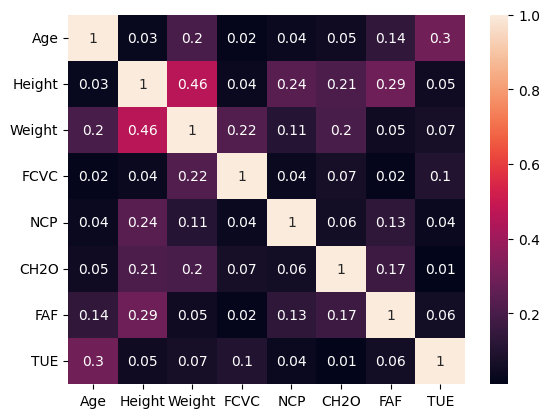

In [ ]:
# Correlation Analysis

float_combined_df = raw_X[["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]]
# find correlation between features and label using correlation matrix
corr_matrix = float_combined_df.corr().round(2).abs()

# display corr matrix as heatmap to visual better
sns.heatmap(data=corr_matrix, annot=True)

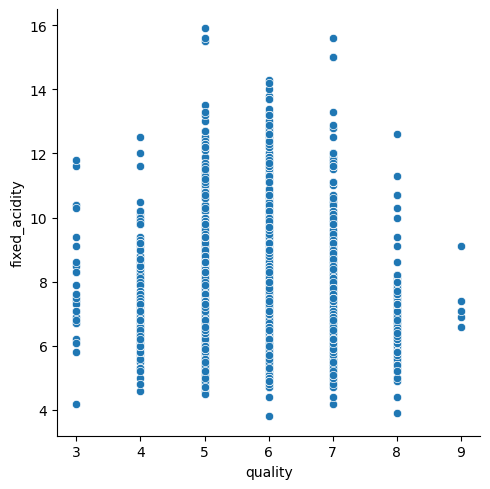

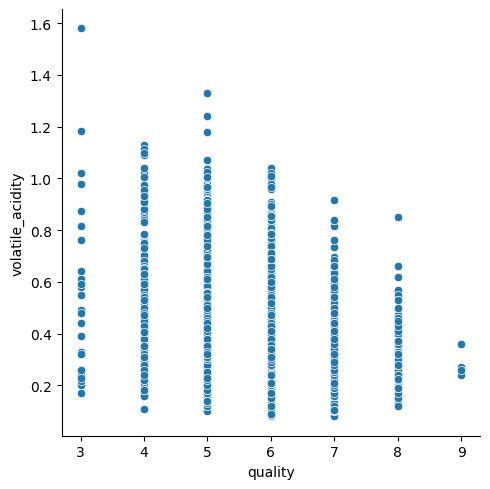

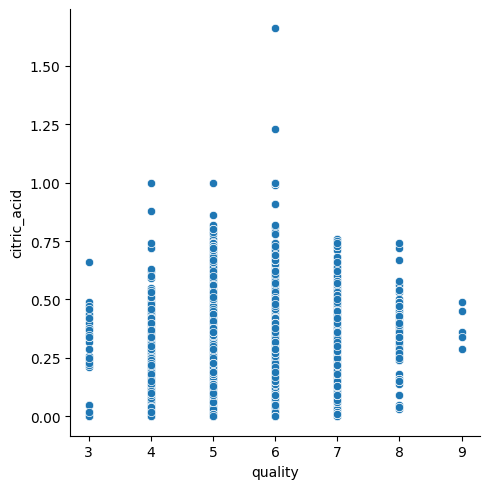

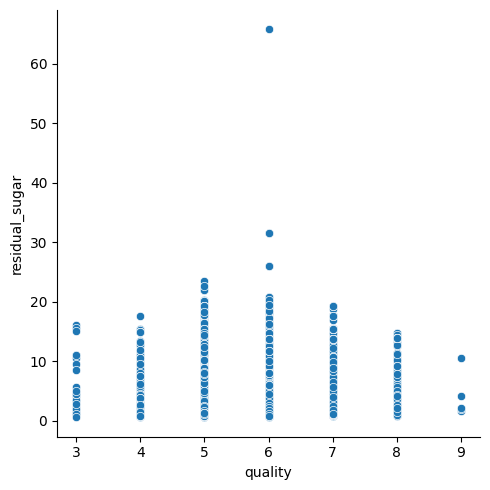

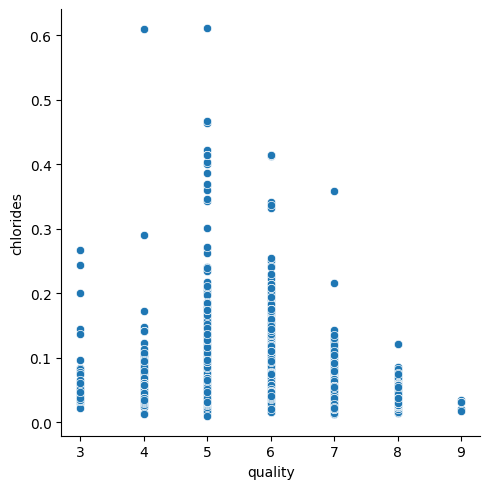

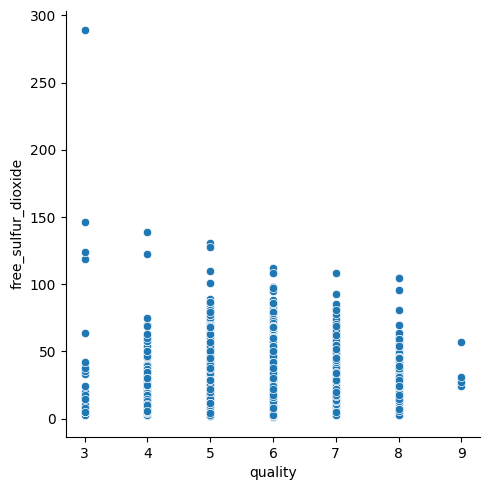

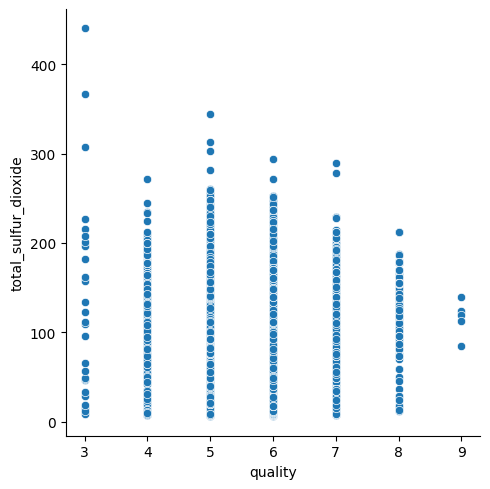

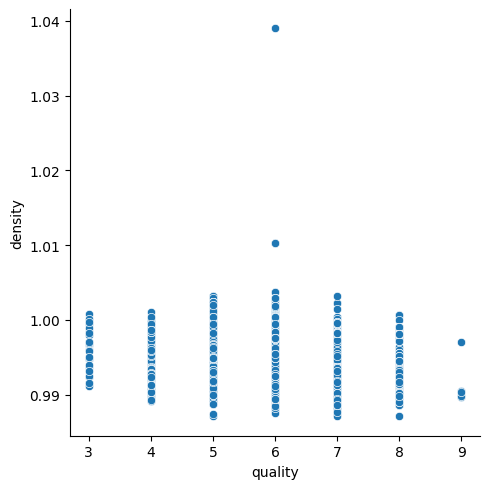

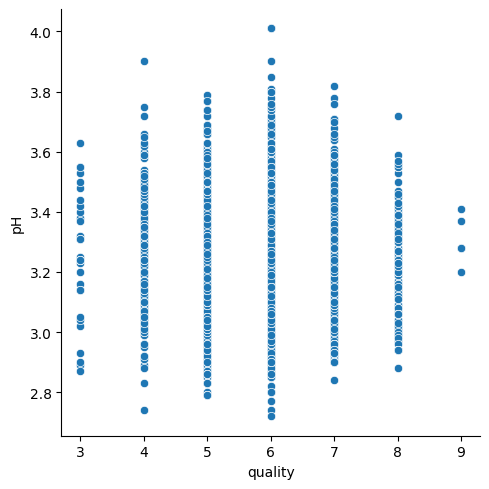

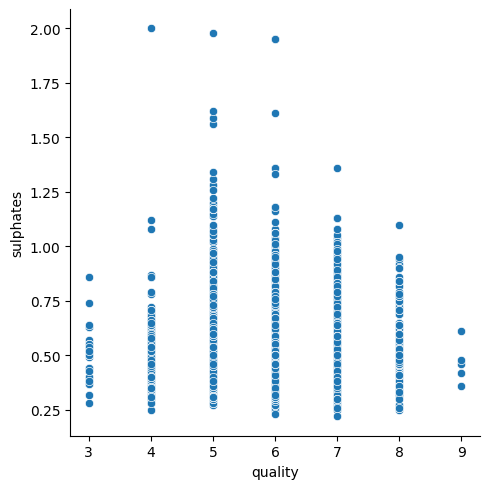

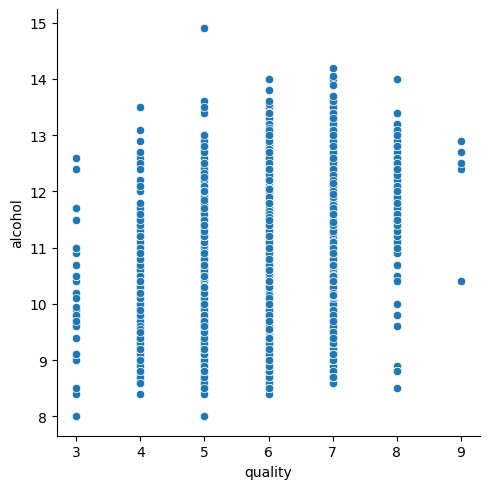

In [ ]:
# sns.relplot(data=combined_df, x="quality", y="fixed_acidity")
# sns.relplot(data=combined_df, x="quality", y="volatile_acidity")
# sns.relplot(data=combined_df, x="quality", y="citric_acid")
# sns.relplot(data=combined_df, x="quality", y="residual_sugar")
# sns.relplot(data=combined_df, x="quality", y="chlorides")
# sns.relplot(data=combined_df, x="quality", y="free_sulfur_dioxide")
# sns.relplot(data=combined_df, x="quality", y="total_sulfur_dioxide")
# sns.relplot(data=combined_df, x="quality", y="density")
# sns.relplot(data=combined_df, x="quality", y="pH")
# sns.relplot(data=combined_df, x="quality", y="sulphates")
# sns.relplot(data=combined_df, x="quality", y="alcohol")
